## This works on "tra" kernal virtual environment

The things we will learn here is about stocks and traing strategies and wht time series data etc.<br>
An introduction to time series data and some of the most common financial analysis, such as <b>moving windows</b>, <b>volatility calculation</b>, with Python package Pandas.<br>
We will develop a <b>simple momentum strategy</b>, first going through the development process step by step and start by formulating and coding up the simple algorithmic trading strategy.<br>
Then we'll <b>backtest</b> the formulated trading strategy with Pandas, zipline and Quantopian.<br>
Then optimizations in the strategy to make it perform better and eventually evaluate strategy's performance and robustness.<br><br>

# Getting Started


In [1]:
import pandas_datareader as pdr
import datetime
import yfinance as yf

In [2]:
# aapl = yf.download('AAPL', start=datetime.datetime(2006, 10, 1), end=datetime.datetime(2012, 1, 1))
# The file has been saved as a CSV, so reading that

The above DataFrame consists of a time series data.

In [3]:
import pandas as pd

In [4]:
aapl = pd.read_csv('data/aapl.csv', parse_dates=['Date'])

In [5]:
aapl.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2006-10-02,2.709643,2.653571,2.682143,2.673571,712639200,2.299011
1,2006-10-03,2.676786,2.613929,2.658929,2.645714,790708800,2.275057
2,2006-10-04,2.695000,2.612857,2.646429,2.692143,829082800,2.314981
3,2006-10-05,2.720000,2.647500,2.661786,2.672500,683883200,2.298089
4,2006-10-06,2.680000,2.636071,2.657857,2.650714,466958800,2.279357


In [6]:
aapl.set_index('Date', inplace=True)

In [7]:
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-10-02,2.709643,2.653571,2.682143,2.673571,712639200,2.299011
2006-10-03,2.676786,2.613929,2.658929,2.645714,790708800,2.275057
2006-10-04,2.695000,2.612857,2.646429,2.692143,829082800,2.314981
2006-10-05,2.720000,2.647500,2.661786,2.672500,683883200,2.298089
2006-10-06,2.680000,2.636071,2.657857,2.650714,466958800,2.279357


In [8]:
aapl['Close'][-10:]

Date
2011-12-16    13.607857
2011-12-19    13.650357
2011-12-20    14.141071
2011-12-21    14.158929
2011-12-22    14.233929
2011-12-23    14.404643
2011-12-27    14.518929
2011-12-28    14.380000
2011-12-29    14.468571
2011-12-30    14.464286
Name: Close, dtype: float64

Besides indexing, you might also want to explore some other techniques to get to know your data a little bit better. You never know what else will show up. Let’s try to <u><b>sample</b> some 20 rows</u> from the data set and then let’s <b>resample</b> the data so that aapl is now at the <u>monthly level instead of daily</u>. You can make use of the sample() and resample() functions to do this:

In [9]:
# sample 20 rows
sample = aapl.sample(20)
print(sample)

                 High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2007-07-02   4.360357   4.260714   4.323214   4.330714   994862400   3.723993
2008-09-17   4.946786   4.565357   4.946071   4.565357  1200455200   3.925764
2010-11-26  11.346429  11.176429  11.205000  11.250000   237585600   9.673907
2009-07-07   4.988571   4.827857   4.945714   4.835714   461596800   4.158245
2007-02-06   3.016786   2.959286   3.016071   3.005357   864393600   2.584315
2011-06-30  12.004643  11.887143  11.953571  11.988214   322954800  10.308697
2008-06-25   6.386786   6.210000   6.236071   6.335357   644450800   5.447793
2009-05-27   4.820714   4.675357   4.706429   4.751786   646422000   4.086075
2009-04-16   4.398214   4.242500   4.256786   4.337500   593446000   3.729828
2009-08-06   5.946786   5.824643   5.913571   5.853929   341616800   5.033810
2008-09-24   4.676786   4.469643   4.545357   4.596786  10470152

In [10]:
# Resample to monthly level
monthly_aapl = aapl.resample('M').mean()
print(monthly_aapl)

                 High        Low       Open      Close        Volume  \
Date                                                                   
2006-10-31   2.780942   2.723279   2.750731   2.754497  6.539980e+08   
2006-11-30   3.078656   3.007245   3.040391   3.048027  6.588040e+08   
2006-12-31   3.136625   3.051393   3.103964   3.088268  8.445396e+08   
2007-01-31   3.220214   3.130643   3.180589   3.174339  1.360489e+09   
2007-02-28   3.095733   3.027951   3.063026   3.061711  7.222292e+08   
...               ...        ...        ...        ...           ...   
2011-08-31  13.637500  13.255326  13.473587  13.455807  7.018521e+08   
2011-09-30  14.186480  13.859524  14.013554  14.017619  5.703547e+08   
2011-10-31  14.350595  13.983061  14.169422  14.186786  6.257823e+08   
2011-11-30  13.888554  13.631650  13.795289  13.743401  4.268429e+08   
2011-12-31  14.130884  13.933554  14.027517  14.033231  3.003111e+08   

            Adj Close  
Date                   
2006-10-31   2.

In [11]:
aapl['diff'] = aapl.Open - aapl.Close


In [12]:
aapl.diff

<bound method DataFrame.diff of                  High        Low       Open      Close     Volume  Adj Close  \
Date                                                                           
2006-10-02   2.709643   2.653571   2.682143   2.673571  712639200   2.299011   
2006-10-03   2.676786   2.613929   2.658929   2.645714  790708800   2.275057   
2006-10-04   2.695000   2.612857   2.646429   2.692143  829082800   2.314981   
2006-10-05   2.720000   2.647500   2.661786   2.672500  683883200   2.298089   
2006-10-06   2.680000   2.636071   2.657857   2.650714  466958800   2.279357   
...               ...        ...        ...        ...        ...        ...   
2011-12-23  14.413929  14.267500  14.274643  14.404643  269399200  12.386595   
2011-12-27  14.610357  14.393571  14.396429  14.518929  265076000  12.484868   
2011-12-28  14.580357  14.333571  14.531786  14.380000  228662000  12.365404   
2011-12-29  14.487500  14.303929  14.407143  14.468571  215978000  12.441566   
2011-12-

In [13]:
# del aapl['diff']

In [14]:
aapl.head()

,High,Low,Open,Close,Volume,Adj Close,diff
Date,,,,,,,
2006-10-02,2.709643,2.653571,2.682143,2.673571,712639200,2.299011,0.008572
2006-10-03,2.676786,2.613929,2.658929,2.645714,790708800,2.275057,0.013215
2006-10-04,2.695000,2.612857,2.646429,2.692143,829082800,2.314981,-0.045714
2006-10-05,2.720000,2.647500,2.661786,2.672500,683883200,2.298089,-0.010714
2006-10-06,2.680000,2.636071,2.657857,2.650714,466958800,2.279357,0.007143


In [15]:
aapl

,High,Low,Open,Close,Volume,Adj Close,diff
Date,,,,,,,
2006-10-02,2.709643,2.653571,2.682143,2.673571,712639200,2.299011,0.008572
2006-10-03,2.676786,2.613929,2.658929,2.645714,790708800,2.275057,0.013215
2006-10-04,2.695000,2.612857,2.646429,2.692143,829082800,2.314981,-0.045714
2006-10-05,2.720000,2.647500,2.661786,2.672500,683883200,2.298089,-0.010714
2006-10-06,2.680000,2.636071,2.657857,2.650714,466958800,2.279357,0.007143
...,...,...,...,...,...,...,...
2011-12-23,14.413929,14.267500,14.274643,14.404643,269399200,12.386595,-0.130000
2011-12-27,14.610357,14.393571,14.396429,14.518929,265076000,12.484868,-0.122499
2011-12-28,14.580357,14.333571,14.531786,14.380000,228662000,12.365404,0.151786


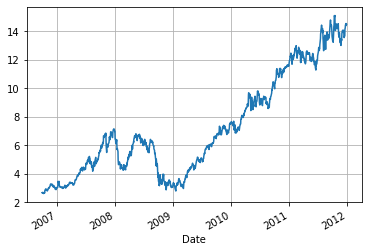

In [16]:
import matplotlib.pyplot as plt

# PLot the closing prices for aapl
aapl['Close'].plot(grid=True)

# Show the plot
plt.show()

# Common Financial Analysis
Learning about <b>returns</b>, <b>moving windows</b>, <b>volatility</b> calculation and <b>Ordinary Least-Squares Regression (OLS)</b>.
## Returns
The <u>simple daily percentage change</u> <i>doesn't take into account dividents</i> and other factors and represents the <u>amount of percentage change</u> in the value of a stock over a <u>single day of trading</u>. We will find that the daily percentage change is easily calculated, as there is a <b>pct_change()</b> function included in the Pandas package to make your life easier.

In [17]:
import numpy as np

In [18]:
daily_close = aapl[['Adj Close']]

In [19]:
daily_close

,Adj Close
Date,
2006-10-02,2.299011
2006-10-03,2.275057
2006-10-04,2.314981
2006-10-05,2.298089
2006-10-06,2.279357
...,...
2011-12-23,12.386595
2011-12-27,12.484868
2011-12-28,12.365404


In [20]:
# Daily returns
daily_pct_change = daily_close.pct_change()

In [21]:
daily_pct_change

,Adj Close
Date,
2006-10-02,NaN
2006-10-03,-0.010419
2006-10-04,0.017549
2006-10-05,-0.007297
2006-10-06,-0.008151
...,...
2011-12-23,0.011994
2011-12-27,0.007934
2011-12-28,-0.009569


In [22]:
daily_pct_change.fillna(0, inplace=True)

In [23]:
daily_pct_change

,Adj Close
Date,
2006-10-02,0.000000
2006-10-03,-0.010419
2006-10-04,0.017549
2006-10-05,-0.007297
2006-10-06,-0.008151
...,...
2011-12-23,0.011994
2011-12-27,0.007934
2011-12-28,-0.009569


In [24]:
# Daily log returns
daily_log_returns = np.log(daily_close.pct_change()+1)
daily_log_returns

,Adj Close
Date,
2006-10-02,NaN
2006-10-03,-0.010474
2006-10-04,0.017397
2006-10-05,-0.007324
2006-10-06,-0.008185
...,...
2011-12-23,0.011922
2011-12-27,0.007903
2011-12-28,-0.009615


Note that we calculate the log returns to get a better insight into the growth of your returns over time.<br>
Knowing how to calculate the daily percentage change is nice, but what when you want to know the monthly or quaterly returns? In such cases, you fall back on the resample().

In [25]:
# Resample aapl to business months, take last observation as value
monthly = aapl.resample('BM').apply(lambda x: x[-1])

# Calculate the monthly percentage change
monthly2 = monthly.pct_change()
monthly2.fillna(0, inplace=True)

# Resample aapl to quarters, take mean as value per quarter
quarter = aapl.resample('4M').mean()

# Calculate the quaterly percentage change
quarter2 = quarter.pct_change()
quarter2.fillna(0, inplace=True)


In [26]:
monthly2.head(20)

,High,Low,Open,Close,Volume,Adj Close,diff
Date,,,,,,,
2006-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-11-30,0.134672,0.134987,0.132105,0.130488,0.735854,0.130488,0.486415
2006-12-29,-0.078550,-0.084560,-0.089578,-0.074405,0.236584,-0.074405,-2.618177
2007-01-31,0.007026,0.011876,0.010840,0.010490,-0.204714,0.010490,-0.022465
2007-02-28,-0.004651,-0.016005,-0.021918,-0.013064,0.074066,-0.013064,0.850543
2007-03-30,0.106075,0.117470,0.135903,0.098097,-0.346847,0.098097,-1.850940
2007-04-30,0.066751,0.074609,0.061625,0.074158,0.026561,0.074158,-0.788328
2007-05-31,0.209604,0.199358,0.199620,0.214329,1.103887,0.214328,-4.862155
2007-06-29,0.014979,0.012966,0.015824,0.007014,-0.122758,0.007014,-0.937499


In [27]:
quarter2.head(20)

,High,Low,Open,Close,Volume,Adj Close,diff
Date,,,,,,,
2006-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-02-28,0.126451,0.121460,0.125777,0.122860,0.369611,0.122860,-2.007580
2007-06-30,0.195413,0.198331,0.196029,0.197735,-0.080296,0.197735,-1.193769
2007-10-31,0.404613,0.392010,0.400961,0.400796,0.306882,0.400796,-0.429622
2008-02-29,0.130711,0.117746,0.127066,0.120394,0.172293,0.120394,-82.429605
2008-06-30,-0.004290,0.005927,-0.003550,0.003673,-0.209762,0.003673,-1.233311
2008-10-31,-0.108879,-0.124618,-0.114267,-0.118803,0.133219,-0.118803,-3.436440
2009-02-28,-0.363388,-0.359305,-0.363639,-0.360865,-0.161601,-0.360865,-1.098423
2009-06-30,0.304359,0.324702,0.312134,0.316588,-0.386935,0.316588,7.972125


### pct_change()
pct_change() calculates the percentage change between the <b>current</b> and <b>prior</b> element. This function by default calculates the percentage change from the immediate previous row. This function is mostly useful in time series data.

In [28]:
# alternative of pct_change()
daily_pct_change2 = daily_close/daily_close.shift(1) - 1
daily_pct_change2

,Adj Close
Date,
2006-10-02,NaN
2006-10-03,-0.010419
2006-10-04,0.017549
2006-10-05,-0.007297
2006-10-06,-0.008151
...,...
2011-12-23,0.011994
2011-12-27,0.007934
2011-12-28,-0.009569


In [29]:
daily_log_returns_shift = np.log(daily_close / daily_close.shift(1))

In [30]:
daily_log_returns_shift

,Adj Close
Date,
2006-10-02,NaN
2006-10-03,-0.010474
2006-10-04,0.017397
2006-10-05,-0.007324
2006-10-06,-0.008185
...,...
2011-12-23,0.011922
2011-12-27,0.007903
2011-12-28,-0.009615


For reference the calculation of the daily percentage change is based ont he following formula <br>
<b><b>$r(t) = (p(t) / p(t-1)) - 1$</b>.<br>
p is the price, t is the time (1 day in this case) and r is the return.

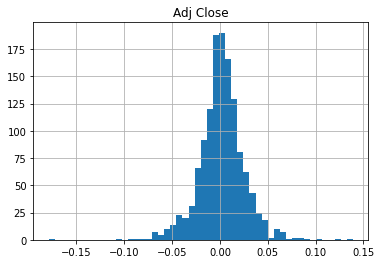

In [31]:
daily_pct_change.hist(bins = 50)
plt.show()

In [32]:
daily_pct_change.describe()

,Adj Close
count,1323.000000
mean,0.001565
std,0.023983
min,-0.179195
25%,-0.010661
50%,0.001646
75%,0.014285
max,0.139049


In [33]:
daily_pct_change.loc[daily_pct_change['Adj Close']==0.00000]

,Adj Close
Date,
2006-10-02,0.0
2008-01-28,0.0
2009-01-23,0.0


The cumulative daily rate of return is useful to determine the value of an investment at regular intervals. You can calculate the cumulative daily rate of return by using the daily percentage change values, adding 1 to them and calculating the cumulative product with the resulting values.

In [34]:
# calculate the cumulative daily returns
cum_daily_return = (1+daily_pct_change).cumprod()
cum_daily_return

,Adj Close
Date,
2006-10-02,1.000000
2006-10-03,0.989581
2006-10-04,1.006947
2006-10-05,0.999599
2006-10-06,0.991451
...,...
2011-12-23,5.387793
2011-12-27,5.430539
2011-12-28,5.378576


<b>cumprod()</b> function is used when we want to compute the <b>cumulative product</b> of array elements over a given axis.
A <u>cumulative product</u> is a <u>sequence of partial products</u> of a given sequence. For example, the cumulative products of the sequence ${a,b,c,...}$, are $a, ab, abc, ....$ 

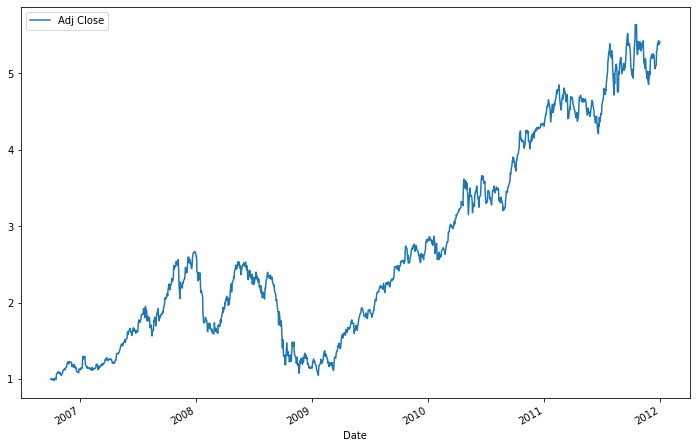

In [35]:
cum_daily_return.plot(figsize=(12, 8))
plt.show()

If you don't want to see the daily returns but rather the monthly returns, we can wasily use the resample() function to brind the cum_daily_return to monthly level.

In [36]:
cum_monthly_return = cum_daily_return.resample('M').mean()
cum_monthly_return

,Adj Close
Date,
2006-10-31,1.030269
2006-11-30,1.140059
2006-12-31,1.155110
2007-01-31,1.187303
2007-02-28,1.145177
...,...
2011-08-31,5.032898
2011-09-30,5.243034
2011-10-31,5.306307


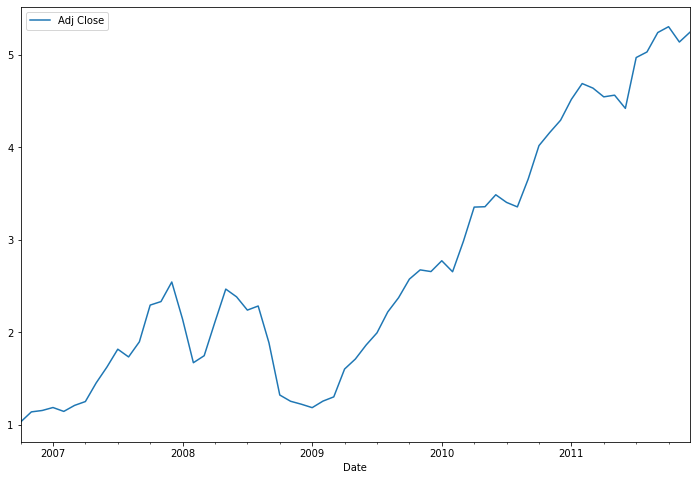

In [37]:
cum_monthly_return.plot(figsize=(12, 8))
plt.show()

Getting how to calculate returns is a valuable, but we won't see much from these numbers when we don't compare to other stock. Thats why we will see examples where 2 or more stocks are compared. We will get more data from Yahoo finance so we can calculate the daily percentage change and compare the results.<br>
<br>
To get more data from yahoo financee we can easily do this by making a function that takes in the ticker or symbol of the stock, a start data and an end date. The next we use is data() then takes the ticker to get your data from the startdate to the enddate and returns it so that the get() function can continue. You map the data with the right tickers and return a DataFrame that concatenates the mapped data with tickers.

In [38]:
def get(tickers, startdate, enddate):
    def data(ticker):
        return (yf.download(ticker, start=startdate, end=enddate))
    
    datas = map(data, tickers)
    return (pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG']
all_data = get(tickers, datetime.datetime(2006, 10, 1), datetime.datetime(2012, 1, 1))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [39]:
all_data.head()

Open      High       Low     Close  Adj Close  \
Ticker Date                                                            
AAPL   2006-10-02  2.682143  2.709643  2.653571  2.673571   2.299011   
       2006-10-03  2.658929  2.676786  2.613929  2.645714   2.275057   
       2006-10-04  2.646429  2.695000  2.612857  2.692143   2.314981   
       2006-10-05  2.661786  2.720000  2.647500  2.672500   2.298089   
       2006-10-06  2.657857  2.680000  2.636071  2.650714   2.279357   

                      Volume  
Ticker Date                   
AAPL   2006-10-02  712639200  
       2006-10-03  790708800  
       2006-10-04  829082800  
       2006-10-05  683883200  
       2006-10-06  466958800

In [40]:
all_data.tail()

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
GOOG   2011-12-23  314.819977  316.154968  314.102661  315.387848  315.387848   
       2011-12-27  314.844879  321.041656  314.819977  318.929565  318.929565   
       2011-12-28  320.174896  321.295715  317.858582  318.655609  318.655609   
       2011-12-29  319.547272  320.299438  316.414001  320.000549  320.000549   
       2011-12-30  319.811279  322.172424  319.811279  321.744019  321.744019   

                    Volume  
Ticker Date                 
GOOG   2011-12-23  2918298  
       2011-12-27  3224842  
       2011-12-28  4270347  
       2011-12-29  3162610  
       2011-12-30  3577961

In [41]:
all_data

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
AAPL   2006-10-02    2.682143    2.709643    2.653571    2.673571    2.299011   
       2006-10-03    2.658929    2.676786    2.613929    2.645714    2.275057   
       2006-10-04    2.646429    2.695000    2.612857    2.692143    2.314981   
       2006-10-05    2.661786    2.720000    2.647500    2.672500    2.298089   
       2006-10-06    2.657857    2.680000    2.636071    2.650714    2.279357   
...                       ...         ...         ...         ...         ...   
GOOG   2011-12-23  314.819977  316.154968  314.102661  315.387848  315.387848   
       2011-12-27  314.844879  321.041656  314.819977  318.929565  318.929565   
       2011-12-28  320.174896  321.295715  317.858582  318.655609  318.655609   
       2011-12-29  319.547272  320.299438  316.414001  320.000549  320.000549   
       2011-12-30  319.811279  322.172424  319.811279  321.744019  321.744019   

                      Volume  
Ticker Date                   
AAPL   2006-10-02  712639200  
       2006-10-03  790708800  
       2006-10-04  829082800  
       2006-10-05  683883200  
       2006-10-06  466958800  
...                      ...  
GOOG   2011-12-23    2918298  
       2011-12-27    3224842  
       2011-12-28    4270347  
       2011-12-29    3162610  
       2011-12-30    3577961  

[5292 rows x 6 columns]

In [42]:
# isolate the 'Adj Close' values and transform the DataFrame
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

In [43]:
daily_close_px

Ticker,AAPL,GOOG,IBM,MSFT
Date,,,,
2006-10-02,2.299011,199.970459,53.570961,20.008602
2006-10-03,2.275057,201.265610,53.426983,20.015917
2006-10-04,2.314981,207.073837,54.375805,20.432760
2006-10-05,2.298089,205.136093,54.258003,20.418131
2006-10-06,2.279357,209.464874,54.401970,20.381563
...,...,...,...,...
2011-12-23,12.386595,315.387848,132.280991,21.147839
2011-12-27,12.484868,318.929565,132.424210,21.155962
2011-12-28,12.365404,318.655609,131.736893,20.977226


In [44]:
# calculate the daily percentage change for the 'daily_close_px'
daily_pct_change4 = daily_close_px.pct_change()


In [45]:
daily_pct_change4

Ticker,AAPL,GOOG,IBM,MSFT
Date,,,,
2006-10-02,NaN,NaN,NaN,NaN
2006-10-03,-0.010419,0.006477,-0.002688,0.000366
2006-10-04,0.017549,0.028859,0.017759,0.020826
2006-10-05,-0.007297,-0.009358,-0.002166,-0.000716
2006-10-06,-0.008151,0.021102,0.002653,-0.001791
...,...,...,...,...
2011-12-23,0.011994,0.005463,0.014887,0.008524
2011-12-27,0.007934,0.011230,0.001083,0.000384
2011-12-28,-0.009569,-0.000859,-0.005190,-0.008448


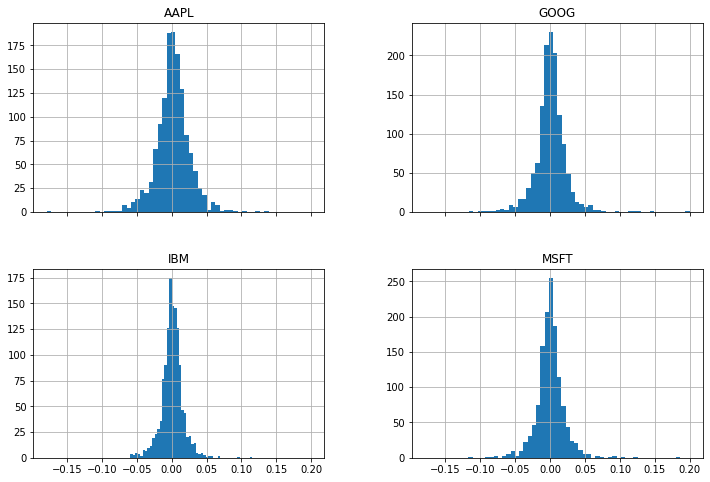

In [46]:
daily_pct_change4.hist(bins=50, sharex=True, figsize=(12,8))
plt.show()

Abother useful plot is the scatter matrix. We use the <b>scatter_matrix()</b> function to your code so that we actually make the scatter matrix. As arguements we pass the daily_pct_change and as a diagonal we set that we want to have Kernal Density Estimate (KDE) plot. Additionally we can set the tranpareency with the alpha arguement and figsure size.

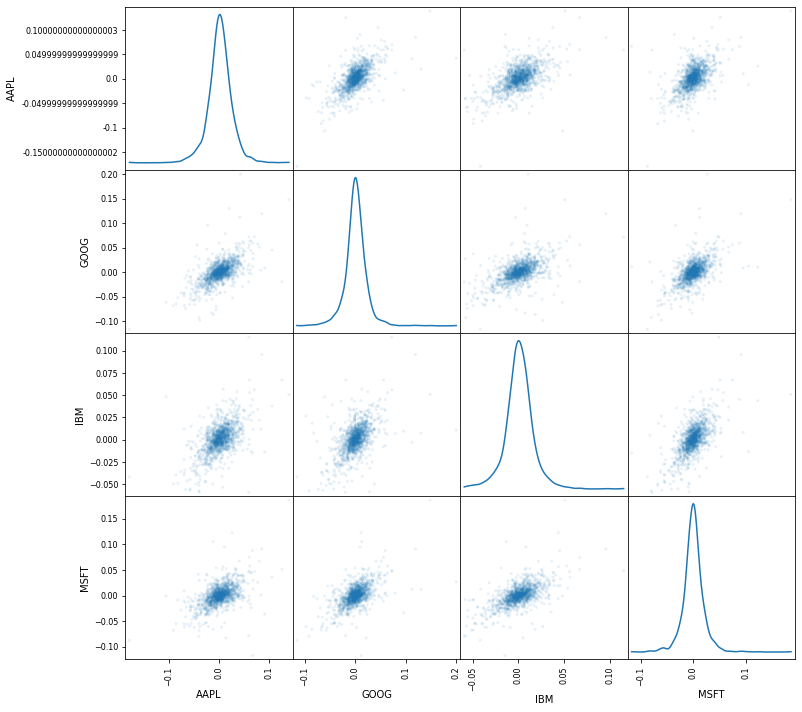

In [47]:
pd.plotting.scatter_matrix(daily_pct_change4, diagonal='kde', alpha=0.1, figsize=(12,12))

plt.show()

# Moving Windows
Moving windows are there when you <u>compute the statistic</u> on a <b>window of data</b> represented by a <b>particular period of time</b> and then <u>slide the window</u> across the data by a <u>specified interval</u>. That way, statistic is <u>continually calculated</u> as long as the window falls first within the dates of time series.<br>
There are a lot of functions in Pandas to calculate the moving windows such as <u>rolling_mean()</u>, <u>rolling_std()</u>, ...<br>
But what does a moving window exactly mean for you?

The exact meaning, of course, depends on the statistic that you’re applying to the data. For example, a rolling mean <b><u>smoothes</u> out <u>short-term fluctuations</u> and <u>highlight longer-term trends</u></b> in data.<br><br>
Just one thing to keep in mind, rolling_mean() is equal to rolling().mean().<br>
Same goes for rolling_median() and rolling_std()

In [48]:
adj_close_px = aapl[['Adj Close']]

In [49]:
adj_close_px

,Adj Close
Date,
2006-10-02,2.299011
2006-10-03,2.275057
2006-10-04,2.314981
2006-10-05,2.298089
2006-10-06,2.279357
...,...
2011-12-23,12.386595
2011-12-27,12.484868
2011-12-28,12.365404


In [50]:
# calculate the moving average
moving_avg = adj_close_px.rolling(window=40).mean()
moving_avg

,Adj Close
Date,
2006-10-02,NaN
2006-10-03,NaN
2006-10-04,NaN
2006-10-05,NaN
2006-10-06,NaN
...,...
2011-12-23,11.918176
2011-12-27,11.919389
2011-12-28,11.917746


In [51]:
moving_med = adj_close_px.rolling(window=40).median()
moving_med

,Adj Close
Date,
2006-10-02,NaN
2006-10-03,NaN
2006-10-04,NaN
2006-10-05,NaN
2006-10-06,NaN
...,...
2011-12-23,11.94528
2011-12-27,11.94528
2011-12-28,11.94528


In [52]:
moving_max = adj_close_px.rolling(window=40).max()
moving_max

,Adj Close
Date,
2006-10-02,NaN
2006-10-03,NaN
2006-10-04,NaN
2006-10-05,NaN
2006-10-06,NaN
...,...
2011-12-23,12.475656
2011-12-27,12.484868
2011-12-28,12.484868


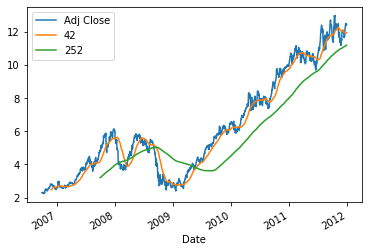

In [53]:
# plotting

# Short moving window rolling mean
aapl['42'] = adj_close_px.rolling(window=40).mean()

# Long moving window rolling mean - 252 trading days in a year
aapl['252'] = adj_close_px.rolling(window=252).mean()

#PLot the adjusted closing price, the short and long windows of rolling means
aapl[['Adj Close', '42', '252']].plot()

plt.show()

# Volatility Calculation
The volatility of a stock is a measurement of the <b>change in variance in the returns</b> of a <u>stock over a specific period of time</u>. It is common to <u>compare the volatility</u> of a stock with another stock to get a feel for which may have less risk of to a market index to examine the stock's volatility in the overall market. Generally, the higher the volatility riskier the investment in that stock which results in investing in one over another.<br>
The moving historical standard deviation of the log returns i.e the moving historical volatility might be of interest. Also make use of <b>pd.rolling_std(data, window=x) * math.sqrt(window)</b> for the moving historical standard deviation of the log returns aka moving historical volatility.<br><br>

$\sigma _p = \sigma _{daily} * \sqrt{p}$<br>
$\sigma _{annually} = \sigma _{daily} * \sqrt{252}$<br>

252 traing years per year, p is the time period or the window size

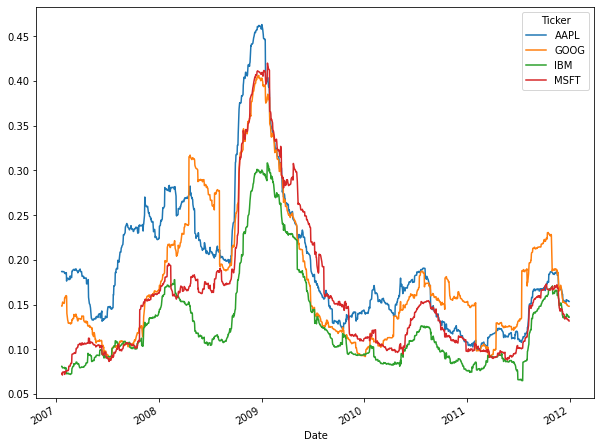

In [54]:
# defining minimum periods to consider
min_periods = 75

# Calculate the volatility
vol = daily_pct_change4.rolling(min_periods).std() * np.sqrt(min_periods)

#plot
vol.plot(figsize=(10,8))
plt.show()

In [55]:
daily_pct_change4

Ticker,AAPL,GOOG,IBM,MSFT
Date,,,,
2006-10-02,NaN,NaN,NaN,NaN
2006-10-03,-0.010419,0.006477,-0.002688,0.000366
2006-10-04,0.017549,0.028859,0.017759,0.020826
2006-10-05,-0.007297,-0.009358,-0.002166,-0.000716
2006-10-06,-0.008151,0.021102,0.002653,-0.001791
...,...,...,...,...
2011-12-23,0.011994,0.005463,0.014887,0.008524
2011-12-27,0.007934,0.011230,0.001083,0.000384
2011-12-28,-0.009569,-0.000859,-0.005190,-0.008448


The volatility is calculated by taking a <b>rolling window standard deviation</b> on the <b>percentage change in a stock</b>. You can clearly see this in the code because you pass daily_pct_change4 and the min_periods to rolling_std().<br>
Note that the size of the window can and will change the overall result: if you take the window wider and make min_periods larger, your result will become less representative. If you make it smaller and make the window more narrow, the result will come closer to the standard deviation.<br><br>

Considering all of this, you see that it’s definitely a skill to get the right window size based upon the data sampling frequency.

# Ordinary Least-Squares Regression (OLS)
To perform more statistical analysis of financial data with more traditional regression analysis, such as the <b>Ordinary Least- Square Regression</b>.<br>
To do this we have to make use of the <b>statsmodels</b> library, which not only provides you with the classes and functions to estimate many different statistical models but also allows you to conduct statistical tests and perform statistical data exploration.

In [56]:
import statsmodels.api as sm


In [57]:
#Isolate the adjusted closing price
all_adj_close = all_data[['Adj Close']]

In [58]:
# calculate the returns
all_returns = np.log(all_adj_close / all_adj_close.shift(1))

# isolate the AAPL returns
aapl_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker')=='AAPL']
aapl_returns.index = aapl_returns.index.droplevel('Ticker')

# isolate the MSFT returns
msft_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker')=='MSFT']
msft_returns.index = msft_returns.index.droplevel('Ticker')

# build a new dataframe with AAPL and MSFT returns
return_data = pd.concat([aapl_returns, msft_returns], axis=1)[1:]
return_data.columns = ['AAPL', 'MSFT']

# Add a constant
X = sm.add_constant(return_data['AAPL'])

# Construct the model
model = sm.OLS(return_data['MSFT'], X).fit()

# print model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     515.5
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.33e-96
Time:                        23:14:01   Log-Likelihood:                 3514.0
No. Observations:                1322   AIC:                            -7024.
Df Residuals:                    1320   BIC:                            -7014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.119      0.2

Note that you add [1:] to the concatenation of the <u>AAPL and MSFT</u> return data so that you don’t have any NaN values that can interfere with your model.

Things to look out for when you’re studying the result of the model summary are the following:
1. The <b>Dep. Variable</b>, which indicates which variable is the response in the model
2. The <b>Model</b>, in this case, is <b>OLS</b>. It’s the model you’re using in the fit.
3. Additionally, you also have the <b>Method</b> to indicate how the parameters of the model were calculated. In this case, you see that this is set at <b>Least Squares</b>.
4. The number of observations <b>(No. Observations)</b>. Note that you could also derive this with the Pandas package by using the <b>info()</b> function. return_data.info()
5. The <b>degree of freedom</b> of the residuals <b>(DF Residuals)</b>.
6. The number of parameters in the model, indicated by <b>DF Model</b>; <u>Note that the number doesn’t include the constant term X which was defined in the code above</u>.

This was about the left column of the summary. The right column gives us some more insights into the goodness of the fit.

7. R-squared, which is the <b>coefficient of determination</b>. This score indicates <u>how well the regression line approximates the real data points</u>. In this case, the result is <u>0.280</u>. In percentages, this means that the <u>score is at 28%</u>. When the score is <b>0%</b>, it indicates that the <u>model explains none of the variability</u> of the response data around its <u>mean</u>. Of course, a score of 100% indicates the opposite.
8. You also see the <b>Adj. R-squared score</b>, which at first sight gives the same number. However, the <u>calculation behind this metric adjusts the R-Squared value based on the number of observations and the degrees-of-freedom of the residuals (registered in DF Residuals)</u>. The adjustment in this case hasn’t had much effect, as the result of the adjusted score is still the same as the regular R-squared score.
9. The <b>F-statistic</b> measures how <u>significant the fit is</u>. It is calculated by <u>dividing the mean squared error</u> of the model by the <u>mean squared error of the residuals</u>. The F-statistic for this model is 515.
10. Next, there’s also the <b>Prob (F-statistic)</b>, which indicates the <u>probability</u> that you would <u>get the result of the F-statistic</u>, given the null hypothesis that they are unrelated.
11. The <b>Log-likelihood</b> indicates the <u>log of the likelihood function</u>, which is, in this case 3514.
12. The <b>AIC</b> is the <b>Akaike Information Criterion</b>: this metric <u>adjusts the log-likelihood</u> based on the <u>number of observations</u> and the <u>complexity of the model</u>. The AIC of this model is -7024.
13. Lastly, the <b>BIC</b> or the <b>Bayesian Information Criterion</b>, is <u>similar to the AIC</u> that you just have seen, but it <u>penalizes models</u> with <u>more parameters more severely</u>. Given the fact that this model only has one parameter (check DF Model), the BIC score will be the same as the AIC score.

Below the first part of the model summary, you see reports for each of the model’s coefficients:

14. The estimated value of the coefficient is registered at <b>coef</b>.
15. <b>std err</b> is the standard error of the estimate of the coefficient.
16. There’s also the <b>t-statistic</b> value, which you’ll find under <b>t</b>. This metric is used to <u>measure how statistically significant a coefficient</u> is.
17. $P > |t|$ indicates the <b>null-hypothesis</b> that the <b>coefficient = 0 is true</b>. If it is <u>less than the confidence level, often 0.05</u>, it indicates that there is a <u>statistically significant relationship between the term and the response</u>. In this case, you see that the constant has a value of 0.263, while AAPL is set at 0.000.

Lastly, there is a final part of the model summary in which you’ll see other statistical tests to assess the distribution of the residuals:

18. <b>Omnibus</b>, which is the <b>Omnibus D’Angostino’s test</b>: it provides a combined <u>statistical test for the presence of skewness and kurtosis</u>.
19. The <b>Prob(Omnibus)</b> is the Omnibus metric turned into a probability.
20. Next, the <b>Skew</b> or Skewness measures the symmetry of the data about the mean.
21. The <b>Kurtosis</b> gives an <u>indication</u> of the <u>shape of the distribution</u>, as it compares the amount of data close to the mean with those far away from the mean (in the tails).
22. <b>Durbin-Watson</b> is a test for the presence of <u>autocorrelation</u>, and the <b>Jarque-Bera</b> is another test of the <u>skewness and kurtosis</u>. You can also turn the result of this test into a probability, as you can see in Prob (JB).
23. Lastly, you have the <b>Cond. No</b>, which tests the <u>multicollinearity</u>.

In [59]:
aapl_returns

,Adj Close
Date,
2006-10-02,NaN
2006-10-03,-0.010474
2006-10-04,0.017397
2006-10-05,-0.007324
2006-10-06,-0.008185
...,...
2011-12-23,0.011922
2011-12-27,0.007903
2011-12-28,-0.009615


In [60]:
msft_returns

,Adj Close
Date,
2006-10-02,0.475415
2006-10-03,0.000366
2006-10-04,0.020612
2006-10-05,-0.000716
2006-10-06,-0.001793
...,...
2011-12-23,0.008488
2011-12-27,0.000384
2011-12-28,-0.008484


In [61]:
return_data

,AAPL,MSFT
Date,,
2006-10-03,-0.010474,0.000366
2006-10-04,0.017397,0.020612
2006-10-05,-0.007324,-0.000716
2006-10-06,-0.008185,-0.001793
2006-10-09,0.005509,-0.005397
...,...,...
2011-12-23,0.011922,0.008488
2011-12-27,0.007903,0.000384
2011-12-28,-0.009615,-0.008484


In [62]:
X

,const,AAPL
Date,,
2006-10-03,1.0,-0.010474
2006-10-04,1.0,0.017397
2006-10-05,1.0,-0.007324
2006-10-06,1.0,-0.008185
2006-10-09,1.0,0.005509
...,...,...
2011-12-23,1.0,0.011922
2011-12-27,1.0,0.007903
2011-12-28,1.0,-0.009615


You can plot the Oridinary Least-Squares Regression with the html of Matplotlib

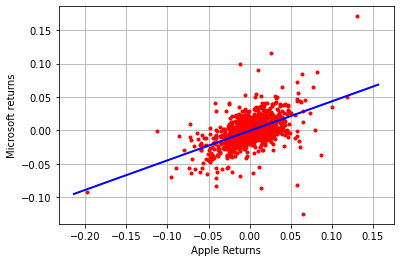

In [63]:
import matplotlib.pyplot as plt

# Plot returns of AAPL and MSFT
plt.plot(return_data['AAPL'], return_data['MSFT'], 'r.')

# Add an axis to the plot
ax = plt.axis()

# Initialize x
x = np.linspace(ax[0], ax[1] + 0.01)

# Plot the regression line
plt.plot(x, model.params[0] + model.params[1] * x, 'b', lw = 2)

# Customize the plot
plt.grid(True)
plt.axis('tight')
plt.xlabel('Apple Returns')
plt.ylabel('Microsoft returns')

plt.show()

Note that you can also use the <b>rolling correlation</b> of <b>returns</b> as a way to <u>crosscheck your results</u>. You can handily make use of the Matplotlib integration with Pandas to call the plot() function on the results of the rolling correlation:

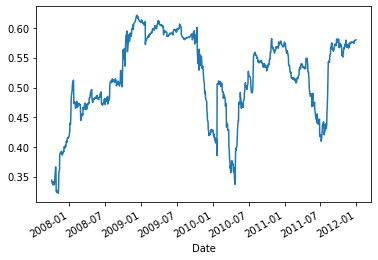

In [64]:
import matplotlib.pyplot as plt

# plot the rolling correlation
return_data['MSFT'].rolling(window=252).corr(return_data['AAPL']).plot()

# Show the plot
plt.show()

# Building a Trading strategy with python
## Common trading strategies
Strategy is a fixed plan to go lond or short in markets, but much more information you didn't really get yet. In general there are 2 common trading strategies: the <b>momentum strategy</b> and the <b>reversion strategy</b>.<br>

First the <b>momentum strategy</b> is also called <b>divergence</b> or <b>trend trading</b>. When you follow this strategy, you do so because you believe the <u>momentum of a quantity will continue in its current direction</u>. Stated differently, you believe that stocks have momentum upward or downward trends that you can detect and exploit.<br>
Some examples of this strategy are the <u>moving average crossover</u>, the <u>dual moving average crossover</u> and <u>turtle trading</u>.
1. The moving average crossover is when the <u>price of an asset moves from one side of a moving average to the other</u>. This crossover represents a <b>change in momentum</b> and can be used as a point of making the decision to enter or exit the market.
2. The <b>dual moving average crossover</b> occurs when a <b><u>short-term average crosses a long-term average</u></b>. This signal is used to identify that <u>momentum is shifting in the direction of the <b>short-term average</b></u>. A <b>buy signal</b> is generated when the <u>short-term average <b>crosses</b> the long-term average and <b>rises above</b> it</u>, while a <b>sell signal</b> is triggered by a <u>short-term average <b>crossing</b> long-term average and <b>falling below</b> it</u>.
3. <b>Turtle trading</b> is a popular trend following strategy that was initially taught by <b>Richard Dennis</b>. The basic strategy is to <u><b>buy</b> futures on a <b>20-day high</b> and <b>sell</b> on a <b>20-day low</b></u>.<br>

Secondly the <b>reversion strategy</b>, which is also known as <b>convergence or cycle trading</b>. This <u>strategy departs</u> from the belief that the <u><b>movement</b> of a quantity will <b>eventually reverse</b></u>. This might seem a little bit abstract, but won't be when we take an example. Take a look at the <b>mean reversion strategy</b>, where we actually <b>believe</b> that stocks <b>return to their mean</b> and that we can <b>exploit</b> when it <u><b>deviates from that mean</b></u>. That is more practical.<br>

Another example of this strategy <b>besides mean reversion strategy</b> is the <b>pairs trading mean-reversion</b>, which is <u>similar to the mean reversion strategy</u>. Whereas the <b>mean reversion</b> strategy basically stated that <u>stocks <b>return</b> to their <b>mean</b></u>, the <u>pairs trading</u> strategy <b>extends</b> this and states that if <b>2 stocks</b> can be identified that have a <b>relatively high correlation</b>, the <u><b>change</b> in the <b>difference</b> in <b>price</b> between the <b>2 stocks</b> can be used to <b>signal</b> trading events if <b>one of the 2</b> moves <b>out of correlation</b> with the other</u>. That means if the <u>correlation between 2 stocks has <b>decreased</b></u>, the <b>stock</b> with the <b>higher priced</b> can be considered to be in a <b>short position</b>. It <u>should be sold</u> because the <u>higher-priced stock will return to the <b>mean</b></u>. The <b>lower-priced stock</b> on the other hand will be in a <b>long position</b> because the <b>price will rise</b> as the <u>correlation will return to normal</u>.

<br>

Besides these 2 most frequent strategies, there are also other ones that you might come accross once in a while, such as the <b>forecasting strategy</b>, which attempts to predict the direction or value of a stock, in this case in subsequent future time periods based on certain historical factors. There is also the high-frequency trading strategy, which exploits sub-milliseconds microstructure.

## A simple trading strategy
We will start the "Hello world" of quantitative trading, the <b>moving average crossover</b>. The strategy that we will be developing is simple, we will create <b>2 separate Simple Moving Averages</b> (SMAs) of a time series with <u>differing lookback periods</u>, let's say <b>40 days</b> and <b>100 days</b>. If the <u><b>short</b> moving average exceeds</u> the long moving average the you go <b>long</b>, if the <u><b>long</b> moving average exceeds</u> the short moving average then we <b>exit</b>.
<br>
Remember that when you go <b>long</b>, you think that the stock <b>price will go up</b> and will sell at a higher price in the future (= <b>buy signal</b>); When you go <b>short</b>, you <b>sell your stock</b>, expecting that you can <b>buy</b> it back at a <b>lower price</b> and realize a profit (= <b>sell signal</b>).

<br>
This simple strategy might seem quite complex when you’re just starting out, but let’s take this step by step:

1. First we define our <b>2 lookback periods</b>: a <b>short</b> window and a <b>long</b> window. We set up 2 variables and assign one integer per variable. Make sure that the integer we assign to the short window is shorter than the integer that we assign to the long window variable!

2. Nest, we make an empty "signals" DataFrame, but do make sure to copy the index of your aapl data so that we can start calculating the daily buy or sell signal for our aapl data.

3. Create a column in our empty "signals" DataFrame that is named "signal" and initialize it be setting the value for all the rows in this column to 0.0.

4. After the preparatory work, it's time to create the set of short and long simple moving avrages over the respective long and short time windows. Make use of the <b>rolling()</b> function to start your rolling window calculations: within the function, specify the <b>window</b> and the <b>min_period</b>, and set the <b>center</b> arguement. In practive this will result in a <b>rolling()</b> function to which you have passed either <b>short_window</b> or <b>long_window</b>, <b>1</b> as the <u>minimum number of observations</u> in the window that are required to have a value and <b>False</b> so that the labels are <u>not set at the center of the window</u>. Next, don't forget to also chain the <b>mean()</b> function so that we can calculate the rolling mean.

5. After we have calculated the mean average of the short and long windows, you should create a signal when the short moving average crosses the long moving average, but only for a period greater than the shortest moving average window. Here it will result in the condition :

`signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:]`

Note that we add the `[short_window:]` to comply with the condition <b>"only for the period greated than the shortest moving average window"</b>. When the condition is true, the initiaized value 0.0 in the <b>signal</b> column will be overwritteen with 1.0. A <b>signal</b> is created! If the condition is false, the original valuee of 0.0 will be kept and no signal is generated. We can use <b>NumPy where()</b> function to set up this condition. Much the same, the variable to which we assign this result is `signals['signal'][short_window]`, because we only want to create signals for the <u>period greated than the shortest moving average window!</u>

6. Lastly, we take the difference of the signals in order to generate actual trading orders. In other words, in this column of your `signals` DataFrame, we will be able to distinguish between long and short positions, whether you are <b>buying</b> or <b>selling</b> the stock.


In [66]:
aapl.head()

,High,Low,Open,Close,Volume,Adj Close,diff,42,252
Date,,,,,,,,,
2006-10-02,2.709643,2.653571,2.682143,2.673571,712639200,2.299011,0.008572,NaN,NaN
2006-10-03,2.676786,2.613929,2.658929,2.645714,790708800,2.275057,0.013215,NaN,NaN
2006-10-04,2.695000,2.612857,2.646429,2.692143,829082800,2.314981,-0.045714,NaN,NaN
2006-10-05,2.720000,2.647500,2.661786,2.672500,683883200,2.298089,-0.010714,NaN,NaN
2006-10-06,2.680000,2.636071,2.657857,2.650714,466958800,2.279357,0.007143,NaN,NaN


In [68]:
# Initialize the short and long windows
short_window = 40
long_window = 100

#Initialize the 'signals' DataFrame with the 'signal' column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create Signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

# Generate trading orders
signals['positions'] = signals['signal'].diff()

print(signals)


            signal  short_mavg  long_mavg  positions
Date                                                
2006-10-02     0.0    2.673571   2.673571        NaN
2006-10-03     0.0    2.659643   2.659643        0.0
2006-10-04     0.0    2.670476   2.670476        0.0
2006-10-05     0.0    2.670982   2.670982        0.0
2006-10-06     0.0    2.666928   2.666928        0.0
...            ...         ...        ...        ...
2011-12-23     1.0   13.859911  13.851739        0.0
2011-12-27     0.0   13.861321  13.862154       -1.0
2011-12-28     0.0   13.859411  13.872518        0.0
2011-12-29     0.0   13.867098  13.891057        0.0
2011-12-30     0.0   13.873875  13.902125        0.0

[1323 rows x 4 columns]


Print out the <b>signals</b> DataFrame and inspect the results. Important to grasp here is what the <b>positions</b> and the <b>signal</b> columns mean in this DataFrame. It will be very important as we move on.

<br>
After understanding the results of i=our trading stratefy, we plot all of this the short and long moving averages, together with the buy and sell signals with matplotlib.

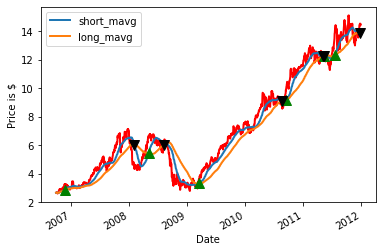

In [74]:
fig = plt.figure()

# Add subplot and label for y-axis
ax1 = fig.add_subplot(111, ylabel='Price is $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# PLot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, signals.short_mavg[signals.positions == 1.0], 
        '^', markersize=10, color='g')

# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, signals.short_mavg[signals.positions == -1.0], 
        'v', markersize=10, color='k')

plt.show()




<AxesSubplot:xlabel='Date'>

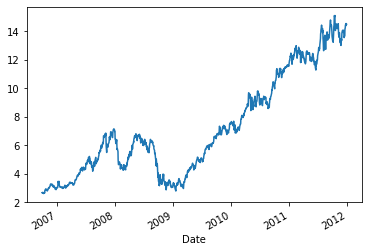

In [72]:
aapl['Close'].plot()

# Backtesting the Trading Strategy
Now that we have our trading strategy at hand, it's a good idea to also backtest it and calculate its performance. But right before we go deeper into this, we might want to know a little bit more about the pitfalls of backtesting, what components are needed in a backtester and what Python tools we can use to backtest a simple algorithm.